In [1]:
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=10 --xla_cpu_enable_fast_math=true'

import jax
print(jax.devices())

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import numpy as np
import jax.numpy as jnp
import jax 
from jax import grad, vmap
jax.config.update("jax_enable_x64", True)


import matplotlib.pyplot as plt

import scipy.interpolate as interp
import scipy.integrate as integ
import scipy.linalg as sla

import fisher_jim_tgr_2par as lib
import pycbc.conversions

import astropy.units as u
from astropy import constants as const

Ms = (u.Msun * const.G / const.c**3 ).si.value
from datetime import datetime
datestr = datetime.now().strftime('%m-%d-%y')

import matplotlib as mpl
from matplotlib.legend_handler import HandlerLine2D, HandlerPatch

def reset_matplotlib():
    # Reset all matplotlib settings to defaults
    mpl.rcdefaults()

    # Create a default handler map and update it globally
    default_handler_map = {
        mpl.lines.Line2D: HandlerLine2D(numpoints=1),
        mpl.patches.Patch: HandlerPatch()
    }

    # Update the default handler map globally
    mpl.legend.Legend.update_default_handler_map(default_handler_map)

# Call this function at the start of your script to globally reset settings
reset_matplotlib()


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7), CpuDevice(id=8), CpuDevice(id=9)]


In [2]:
# Ground stuff
n_freq = 2000
fmin = 10.
fmax = 1000.
freqs = jnp.logspace(jnp.log10(fmin), jnp.log10(fmax), num = int(n_freq))


full_str = ["M_c", "eta", "d_L", "ra", "dec", "iota", "psi", "t_c", "phase_c", "zco", "rng", "Mc_source", "snr_H1", "snr_L1", "snr_V1", "snr_t"]
names = full_str[0:9]
# data = np.loadtxt("data/events.txt")
data = jnp.array(np.loadtxt("data/5-year-data-O3/5-year-data-O3-events.txt"))
# data = jnp.array(nnp.loadtxt("data/5-year-data-CE/5-year-data-CE-events.txt"))

psd = lib.read_mag(freqs, "curves/o3_l1.txt")**2
# psd = lib.read_mag(freqs, "../curves/ce1.txt")**2

data_150914 = np.array(data[0])
data_150914[0] = 30
q  = 0.79
data_150914[1] = q/(1+q)**2
data_150914[2] = 390

idx = '150914'
if idx=='150914':
    dat = jnp.array(data_150914)

red_param = dict(zip(names, jnp.array(dat).T))

In [ ]:
from jimgw.detector import H1, L1, V1
from jimgw.waveform import RippleIMRPhenomPv2, RippleIMRPhenomD
import jax
import jax.numpy as jnp
from jax import grad, vmap

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", True)
# Assuming 'waveform' is defined elsewhere, or you can import it
waveform = RippleIMRPhenomPv2(f_ref=20)
# waveform = RippleIMRPhenomD(f_ref=20)

def get_h_slow(x, f, detector):
    # Set default parameters
    

    ff = jnp.array([f])
    h_sky = waveform(ff, x)
    align_time = jnp.exp(-1j * 2 * jnp.pi * ff * (x['epoch'] + x['t_c']))
    signal = detector.fd_response(ff, h_sky, x) * align_time
    return signal[0]

# Create generic functions for each detector
def get_h_nojit(x, f, detector):
    return vmap(lambda f_single: get_h_slow(x, f_single, detector))(f)



red_param = dict(zip(names, jnp.array(dat).T))
epsilon = jnp.array(1e-6)
for key in ['s1_x', 's1_y', 's1_z', 's2_x', 's2_y', 's2_z']:
    red_param[key] = epsilon
zero_vector = jnp.array(0.)
for key in ['gmst', 'epoch']:
    red_param[key] = zero_vector

x = red_param.copy()
# x['s1_z'] = 0.2
gr_param_diff = names + ['s1_z', 's1_x']

get_h1 = jax.jit(lambda x : get_h_nojit(x, freqs, H1))
get_h2 = jax.jit(lambda x : get_h_nojit(x, freqs, L1))
get_h3 = jax.jit(lambda x : get_h_nojit(x, freqs, V1))


get_h = lambda x : {'H1': get_h1(x), 'L1': get_h2(x), 'V1': get_h3(x)}


h = get_h(x)

keys = list(x.keys())
idx_diff = tuple(i for i, key in enumerate(keys) if key in gr_param_diff)

def f_wrapped(*args, freqs = None, det= None):
    x = dict(zip(keys, args)) 
    return get_h_nojit(x, freqs, det)

get_dh1 = jax.jit(jax.jacfwd(lambda *x: f_wrapped(*x, freqs = freqs, det = H1), argnums = idx_diff))
get_dh2 = jax.jit(jax.jacfwd(lambda *x: f_wrapped(*x, freqs = freqs, det = L1), argnums = idx_diff))
get_dh3 = jax.jit(jax.jacfwd(lambda *x: f_wrapped(*x, freqs = freqs, det = V1), argnums = idx_diff))

def get_dh_gr(x):
    xvalues = list(x.values())

    dh = {'H1': dict(zip(gr_param_diff, get_dh1(*xvalues))) , 'L1': dict(zip(gr_param_diff, get_dh2(*xvalues))), 'V1': dict(zip(gr_param_diff, get_dh3(*xvalues)))}
    return dh

dh = get_dh_gr(x)

In [5]:
from jimgw.detector import H1, L1, V1
from jimgw.waveform import RippleIMRPhenomPv2, RippleIMRPhenomD
import jax
import jax.numpy as jnp
from jax import grad, vmap

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", True)
# Assuming 'waveform' is defined elsewhere, or you can import it
waveform = RippleIMRPhenomPv2(f_ref=20)
# waveform = RippleIMRPhenomD(f_ref=20)

def get_h_slow2(x, detector):
    # Set default parameters
    
    # freqs
    # ff = jnp.array([f])
    ff = jnp.logspace(jnp.log10(fmin), jnp.log10(fmax), num = int(n_freq))
    h_sky = waveform(ff, x)
    align_time = jnp.exp(-1j * 2 * jnp.pi * ff * (x['epoch'] + x['t_c']))
    signal = detector.fd_response(ff, h_sky, x) * align_time
    
    return signal


red_param = dict(zip(names, jnp.array(dat).T))
epsilon = jnp.array(1e-6)
for key in ['s1_x', 's1_y', 's1_z', 's2_x', 's2_y', 's2_z']:
    red_param[key] = epsilon
zero_vector = jnp.array(0.)
for key in ['gmst', 'epoch']:
    red_param[key] = zero_vector

x = red_param.copy()

get_h_slow2(x, H1)

Array([-4.78942466e-23-6.34613154e-23j,
        2.00649248e-24-7.92591784e-23j,
        5.05948519e-23-6.07555986e-23j, ...,
        0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j], dtype=complex128)

In [ ]:
get_h1 = jax.jit(lambda x : get_h_slow2(x, H1))
get_h2 = jax.jit(lambda x : get_h_slow2(x, L1))
get_h3 = jax.jit(lambda x : get_h_slow2(x, V1))
get_h = lambda x : {'H1': get_h1(x), 'L1': get_h2(x), 'V1': get_h3(x)}
h = get_h(x)

def f_wrapped(*args, det = None):
    x = dict(zip(keys, args)) 
    return get_h_slow2(x, det)

gr_param_diff = names + ['s1_z', 's1_x']
keys = list(x.keys())
idx_diff = tuple(i for i, key in enumerate(keys) if key in gr_param_diff)

get_dh1 = jax.jit(jax.jacfwd(lambda *x: f_wrapped(*x, det = H1), argnums = idx_diff))
get_dh2 = jax.jit(jax.jacfwd(lambda *x: f_wrapped(*x, det = L1), argnums = idx_diff))
get_dh3 = jax.jit(jax.jacfwd(lambda *x: f_wrapped(*x, det = V1), argnums = idx_diff))

def get_dh_gr(x):
    xvalues = list(x.values())

    dh = {'H1': dict(zip(gr_param_diff, get_dh1(*xvalues))) , 'L1': dict(zip(gr_param_diff, get_dh2(*xvalues))), 'V1': dict(zip(gr_param_diff, get_dh3(*xvalues)))}
    return dh

dh = get_dh_gr(x)

In [11]:
%timeit  get_dh_gr(x)

2.69 ms ± 20.1 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [4]:
k_inj = 1
k_rec = 3

In [5]:
norm = np.abs(lib.get_dpsi_ppe(20, red_param, k_inj)- lib.get_dpsi_ppe(6000, red_param, k_inj)) 
dpsi_inj = 0.1/norm*lib.get_dpsi_ppe(freqs, red_param, k_inj)

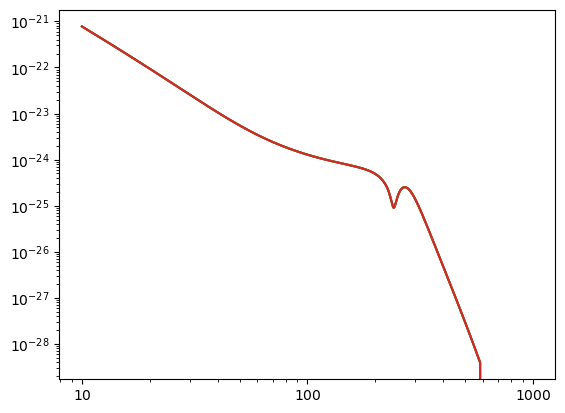

In [6]:
f = jax.jacfwd(lambda *x: f_wrapped(*x, freqs = freqs, det = H1))
xvalues = list(x.values())
plt.loglog(freqs, jnp.abs(f(*xvalues)))
plt.loglog(freqs, jnp.abs(get_dh1(*xvalues)[0]))
plt.loglog(freqs, jnp.abs(dict(zip(gr_param_diff, get_dh1(*xvalues)))["M_c"]))
plt.loglog(freqs, jnp.abs(dh["H1"]["M_c"]))


In [8]:
paramx = ['M_c', 'eta', 'd_L', 'ra', 'dec', 'iota', 'psi', 't_c', 'phase_c']
idx_x = {paramx[i] : i for i in range(len(paramx))}
# %timeit compute_bias(dh["H1"], h["H1"], psd, freqs, idx_x)
log_flag =  {paramx[i] : 0 for i in range(len(paramx))}; log_flag["M_c"] = 1; log_flag["d_L"] = 1
logmult = {paramx[i]: (x[paramx[i]] if log_flag[paramx[i]] else 1) for i in range(len(paramx))}

In [9]:
import pandas as pd 

display(pd.DataFrame(fishslowog(freqs, dh["H1"], x, idx_x, psd, log_flag) ,paramx,paramx))
pd.DataFrame(np.abs(fishslow(freqs, dh["H1"], x, idx_x, psd, log_flag)-lib.fish(freqs, dh["H1"], x, idx_x, psd, log_flag))/fishslow(freqs, dh["H1"], x, idx_x, psd, log_flag),paramx,paramx)

NameError: name 'fishslowog' is not defined

In [10]:
# def innprodslow(hf1, hf2, psd, freqs):
#     prod = 2. * jax.scipy.integrate.trapezoid( (jnp.conj(hf1) * hf2 + hf1 * jnp.conj(hf2)) / psd , freqs)
#     return prod

jax.config.update("jax_enable_x64", True)
def innprodslow(hf1, hf2, psd, freqs):
    integrand = (jnp.conj(hf1) * hf2 + hf1 * jnp.conj(hf2)) / psd
    prod = 2. * jnp.trapezoid(integrand, freqs)
    return prod

freqs = jnp.array(freqs, dtype=jnp.float64)
psd = jnp.array(psd, dtype=jnp.float64)
innprodfast = jax.jit(innprodslow)

dh_dim  = {key: logmult[key] * dh["H1"][key] for key in logmult}
i1 = "d_L"; i2 = 't_c'
hf1 = dh_dim[i1].copy(); hf2 = dh_dim[i2].copy()
innprodslow(hf1,hf2, psd, freqs), innprodfast(hf1,hf2, psd, freqs)

(Array(-1.81415985e-12+0.j, dtype=complex128),
 Array(-2.12628272e-12+0.j, dtype=complex128))

In [17]:
def fishslowog(freqs, dh, par, idx_par, psd, log_flag):

    n_pt = len(freqs)
    n_dof = len(idx_par)

    dh_arr = jnp.zeros([n_dof, n_pt], dtype=np.complex128)

    for idx in idx_par:
        dh_arr = dh_arr.at[idx_par[idx],:].set(dh[idx])
        # dh_arr[idx_par[idx],:] = dh[idx]

        if log_flag[idx]:
            # dh_arr[idx_par[idx]] *= par[idx]
            dh_arr = dh_arr.at[idx_par[idx],:].set(dh_arr[idx_par[idx]] * par[idx])
            

    gamma = jnp.zeros([n_dof, n_dof], dtype=np.float64)

    for i in range(n_dof):
        for j in range(i, n_dof):
            # gamma[i, j] = jnp.real(innprod(dh_arr[i, :], dh_arr[j, :], psd, freqs))
            gamma = gamma.at[i, j].set(np.real(lib.innprod(dh_arr[i, :], dh_arr[j, :], psd, freqs)))

    for i in range(n_dof):
        for j in range(i):
            # gamma[i, j] = jnp.conj(gamma[j, i])
            gamma = gamma.at[i, j].set(jnp.conj(gamma[j, i]))

    return gamma

def fishslow(freqs, dh, par, idx_par, psd, log_flag):
    n_pt = len(freqs)
    n_dof = len(idx_par)

    dh_arr = jnp.zeros([n_dof, n_pt], dtype=jnp.complex128)

    # Convert idx_par to a list for static looping
    idx_list = list(idx_par.keys())
    for idx in idx_list:
        idx_position = idx_par[idx]
        dh_arr = dh_arr.at[idx_position, :].set(dh[idx])

        # Use jax.lax.cond for conditional multiplication
        dh_arr = dh_arr.at[idx_position, :].set(
            jax.lax.cond(
                log_flag[idx],
                lambda x: x * par[idx],
                lambda x: x,
                dh_arr[idx_position, :]
            )
        )

    gamma = jnp.zeros([n_dof, n_dof], dtype=jnp.float64)

    # Use static loops
    for i in range(n_dof):
        for j in range(i, n_dof):
            gamma = gamma.at[i, j].set(
                jnp.real(innprod(dh_arr[i, :], dh_arr[j, :], psd, freqs))
            )
        for j in range(i):
            gamma = gamma.at[i, j].set(jnp.conj(gamma[j, i]))

    return gamma


fish = jax.jit(fishslow)
fish(freqs, dh["H1"], x, idx_x, psd, log_flag)

Array([[ 2.62216129e+061, -1.68436639e+034, -1.09138562e+080,
         4.04552799e+032,  7.26190576e+032,  3.31339310e+029,
        -1.93651101e+032, -4.44130174e+034,  2.04953691e+032],
       [-1.68436639e+034,  1.50209072e+007, -2.14240839e+052,
        -4.78321848e+005, -1.02365316e+006,  4.74999453e+003,
         1.89497146e+005,  6.04023906e+007, -2.00777339e+005],
       [-1.09138562e+080, -2.14240839e+052,  1.99562475e+101,
        -7.57196791e+051, -3.09169122e+051, -7.89080809e+051,
         3.23326046e+050, -4.60668673e+037,  2.52905522e+045],
       [ 4.04552799e+032, -4.78321848e+005, -7.57196791e+051,
         2.11212806e+004,  5.05904393e+004,  1.62432783e+002,
        -6.66368128e+003, -2.90130925e+006,  7.04606038e+003],
       [ 7.26190576e+032, -1.02365316e+006, -3.09169122e+051,
         5.05904393e+004,  1.27089023e+005, -1.83354449e+002,
        -1.48457017e+004, -7.24893387e+006,  1.57212320e+004],
       [ 3.31339310e+029,  4.74999453e+003, -7.89080809e+051,
   

In [26]:
fish = jax.jit(fishslow)
fish(freqs, dh["H1"], x, idx_x, psd, log_flag)

KeyError: 'dphi_rec'

In [16]:
%timeit compute_mm(1,2)

221 ms ± 7.55 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
def compute_bias(dhdtheta, Dh, psd, freqs, idx_par):
    res = { key : jnp.real(innprod(dhdtheta[key], Dh, psd, freqs)) for key in idx_par.keys()}
    bias = [res[key] for key, index in sorted(idx_par.items(), key=lambda item: item[1])]
    return jnp.real(jnp.array(bias))
# jax.jit(compute_bias_slow)(get_h["H1"],get_h["H1"],psd, )

def compute_mm(k_inj, k_rec):
    paramx = ['M_c', 'eta', 'd_L', 'ra', 'dec', 'iota', 'psi', 't_c', 'phase_c', 'dphi_rec']
    log_flag =  {paramx[i] : 0 for i in range(len(paramx))}; log_flag["M_c"] = 1; log_flag["d_L"] = 1
    x = red_param.copy()

    norm = np.abs(lib.get_dpsi_ppe(20, red_param, k_inj)- lib.get_dpsi_ppe(6000, red_param, k_inj)) 
    dpsi_inj = 0.1/norm*lib.get_dpsi_ppe(freqs, red_param, k_inj)
    dpsi_rec = lib.get_dpsi_ppe(freqs, red_param, k_rec)
    dephasing_inj = 1j* dpsi_inj #jnp.exp(1j*dpsi_inj)
    dephasing_rec = 1j* dpsi_rec #jnp.exp(1j*dpsi_rec)

    
    h_H1 = h["H1"]
    h_L1 = h["L1"]
    h_V1 = h["V1"]

    Dh_H1 = dephasing_inj*h_H1
    Dh_L1 = dephasing_inj*h_L1
    Dh_V1 = dephasing_inj*h_V1


    dh_H1 = dh["H1"]
    dh_L1 = dh["L1"]
    dh_V1 = dh["V1"]


    dh_H1['dphi_rec'] = 1j*dpsi_rec*h_H1
    dh_L1['dphi_rec'] = 1j*dpsi_rec*h_L1
    dh_V1['dphi_rec'] = 1j*dpsi_rec*h_V1

    idx_x = {paramx[i] : i for i in range(len(paramx))}
    fi_H1 = lib.fish(freqs, dh_H1, x, idx_x, psd, log_flag)
    fi_L1 = lib.fish(freqs, dh_L1, x, idx_x, psd, log_flag)
    fi_V1 = lib.fish(freqs, dh_V1, x, idx_x, psd, log_flag)
    fi = fi_H1 + fi_L1 + fi_V1


    for i in paramx:
        if log_flag[i]:
            dh_H1[i] = dh_H1[i] * x[i]
            dh_L1[i] = dh_L1[i] * x[i]
            dh_V1[i] = dh_V1[i] * x[i]





    V = compute_bias(dh_H1, Dh_H1, psd, freqs, idx_x) + compute_bias(dh_L1, Dh_L1, psd, freqs, idx_x) + compute_bias(dh_V1, Dh_V1, psd, freqs, idx_x)
    V = np.array(V)
    lam = V @ sla.inv(fi)

    dh_theta = np.array([dh_H1[s] for s in idx_x])

    dhtot = Dh_H1
    dhperp = (dhtot - lam @ dh_theta)
    dhpara = lam @ dh_theta

    mm = (1/2 * innprod(dhperp,dhperp, psd,freqs)/innprod(h_H1,h_H1,psd,freqs))
    return mm 
h = get_h(x)
dh = get_dh_gr(x)
innprod = jax.jit(lib.innprod)

jnp.real(innprod(h["H1"],h["H1"],psd, freqs))

ii = [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7]

mmarr = np.zeros((len(ii),len(ii)))
for i in ii:
    print(i)
    for j in ii:
        # print(i,j)
        mmarr[i,j] = np.real(compute_mm(i, j))

-2
-1


KeyboardInterrupt: 

In [9]:
ii = [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7]

mmarr = np.zeros((len(ii),len(ii)))
# compute_mm(1, 3)
for i in ii:
    for j in ii:
        print(i,j)
        mmarr[i,j] = np.real(compute_mm(i, j))

-2 -2
-2 -1
-2 0
-2 1
-2 2
-2 3
-2 4
-2 5
-2 6
-2 7
-1 -2
-1 -1
-1 0


KeyboardInterrupt: 

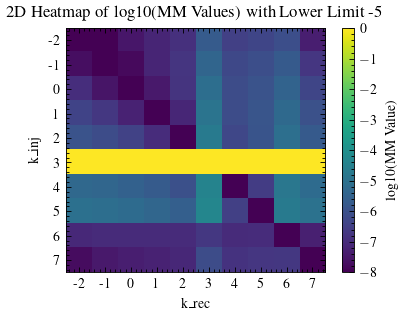

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming mmarr has been computed as a 2D array with real values
# Replace any non-positive values with a small positive number to avoid issues with log10
mmarr_safe = np.where(mmarr > 0, mmarr, np.nan)  # replace non-positive with NaN
log_mmarr = np.log10(mmarr_safe)

# Create the heatmap with a color range limited to -5 and max value of the data
plt.imshow(log_mmarr, cmap='viridis', interpolation='nearest', aspect='auto', vmin=-8, vmax=0)

# Add color bar for reference
plt.colorbar(label='log10(MM Value)')

# Label axes
plt.xlabel("k_rec")
plt.ylabel("k_inj")

# Set x and y ticks to match your ii indices
plt.xticks(ticks=np.arange(len(ii)), labels=ii)
plt.yticks(ticks=np.arange(len(ii)), labels=ii)

# Add title
plt.title("2D Heatmap of log10(MM Values) with Lower Limit -5")
plt.savefig("mm_heatmap.pdf")
# Show the plot
plt.show()


In [18]:
mmarr

array([[4.43547014e-28, 9.78883539e-09, 3.09383147e-08,
        6.71678562e-08, 1.24930933e-07, 1.91624603e-06,
        3.19106538e-07, 4.55702354e-07, 8.07928800e-07,
        4.78310482e-08],
       [2.03092420e-08, 2.52876170e-27, 1.57070161e-08,
        6.87611031e-08, 1.70132867e-07, 4.13878284e-06,
        5.44039012e-07, 8.16710544e-07, 1.90167504e-06,
        1.90897005e-07],
       [1.14972049e-07, 2.81336848e-08, 2.12248886e-26,
        3.54137704e-08, 1.56084107e-07, 7.54349629e-06,
        7.09028785e-07, 1.14598979e-06, 3.50019351e-06,
        4.58188603e-07],
       [4.02804883e-07, 1.98752860e-07, 5.71491520e-08,
        1.60187762e-26, 7.03233630e-08, 1.23890368e-05,
        7.08794804e-07, 1.29595380e-06, 5.60867147e-06,
        9.46747092e-07],
       [1.11415910e-06, 7.31312103e-07, 3.74576302e-07,
        1.04578792e-07, 2.48172799e-25, 1.90532667e-05,
        5.03611282e-07, 1.16067841e-06, 8.22688591e-06,
        1.85072498e-06],
       [2.86638408e+15, 2.95297595e

old stuff

In [25]:
dpsi_inj = 0.1*lib.get_dpsi_ppe(freqs, red_param, k_inj)
dpsi_rec = lib.get_dpsi_ppe(freqs, red_param, k_rec)
dephasing_inj = jnp.exp(1j*dpsi_inj)
dephasing_rec = jnp.exp(1j*dpsi_rec)

h_H1 = get_h(x, freqs,H1)
h_L1 = get_h(x, freqs,L1)
h_V1 = get_h(x, freqs,V1)

Dh_H1 = dephasing*h_H1
Dh_L1 = dephasing*h_L1
Dh_V1 = dephasing*h_V1

dh_H1 = get_dh(x, freqs,H1)
dh_L1 = get_dh(x, freqs,L1)
dh_V1 = get_dh(x, freqs,V1)


dh_H1['dphi_rec'] = 1j*dpsi_rec*h_H1
dh_L1['dphi_rec'] = 1j*dpsi_rec*h_L1
dh_V1['dphi_rec'] = 1j*dpsi_rec*h_V1

In [26]:
idx_x = {paramx[i] : i for i in range(len(paramx))}
fi_H1 = lib.fish(freqs, dh_H1, x, idx_x, psd, log_flag)
fi_L1 = lib.fish(freqs, dh_L1, x, idx_x, psd, log_flag)
fi_V1 = lib.fish(freqs, dh_V1, x, idx_x, psd, log_flag)
fi = fi_H1 + fi_L1 + fi_V1

#do this afterward I unfortunately already implemented it 
for i in paramx:
    if log_flag[i]:
        dh_H1[i] = dh_H1[i] * x[i]
        dh_L1[i] = dh_L1[i] * x[i]
        dh_V1[i] = dh_V1[i] * x[i]

In [32]:
def compute_bias(dhdtheta, Dh, psd, freqs, idx_par):
    res = { key : jnp.real(lib.innprod(dhdtheta[key], Dh, psd, freqs)) for key in idx_par.keys()}
    bias = [res[key] for key, index in sorted(idx_par.items(), key=lambda item: item[1])]
    return jnp.real(jnp.array(bias))



V = compute_bias(dh_H1, Dh_H1, psd, freqs, idx_x) + compute_bias(dh_L1, Dh_L1, psd, freqs, idx_x) + compute_bias(dh_V1, Dh_V1, psd, freqs, idx_x)
V = np.array(V)
lam = V @ sla.inv(fi)

dh = np.array([dh_H1[s] for s in idx_x])

dhtot = Dh_H1
dhperp = (dhtot - lam @ dh)
dhpara = lam @ dh

mm = (1/2 * lib.innprod(dhperp,dhperp, psd,freqs)/lib.innprod(h_H1,h_H1,psd,freqs))